In [1]:
import requests
from bs4 import BeautifulSoup
import re

from dateutil import parser

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#for calendar charts — https://pythonhosted.org/calmap/
#pip install calmap
import calmap


## Posts

In [2]:
soup = BeautifulSoup(open("facebook-data/posts/your_posts.html"), "html.parser")
posts = soup.findAll('div', class_='_4t5n')[0].findAll('div', class_='pam _3-95 _2pi0 _2lej uiBoxWhite noborder')

In [3]:
post_data = []
for num in range(len(posts)):
    post = posts[num]
    
    try:
        post_title = post.find('div', class_='_3-96 _2pio _2lek _2lel').text
    except:
        post_title = ''
        
    try:
        post_status = post.find('div', class_='_3-96 _2let').find('div', class_='_2pin').text.encode('utf-8')
    except:
        post_status = ''
    
    try:
        post_time = post.find('div', class_='_3-94 _2lem').text
    except:
        post_time = ''
        
    post_data.append([num, post_title, post_status, post_time])

In [4]:
post_df = pd.DataFrame(post_data)
post_df.columns = ['num', 'title', 'status', 'time']
post_df = post_df[post_df.time!='']
post_df.time = pd.to_datetime(post_df.time)
post_df.index = post_df.time

post_df['status_length'] = post_df.status.apply(lambda text: len(text))

#UPDATE NAME

#Analysis without photos
post_count = post_df[post_df.title!='Samarth Bansal added a new photo.'].resample("D").count()

#Analysis with photo uploads
#post_count = post_df.resample("D").count()

In [5]:
post_count.sum()#sort_values('time')

num              1324
title            1324
status           1324
time             1324
status_length    1324
dtype: int64

/anaconda/lib/python2.7/site-packages/calmap/__init__.py:294: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  by_day = data.resample('D', how=how)
/anaconda/lib/python2.7/site-packages/calmap/__init__.py:146: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  linecolor = ax.get_axis_bgcolor()


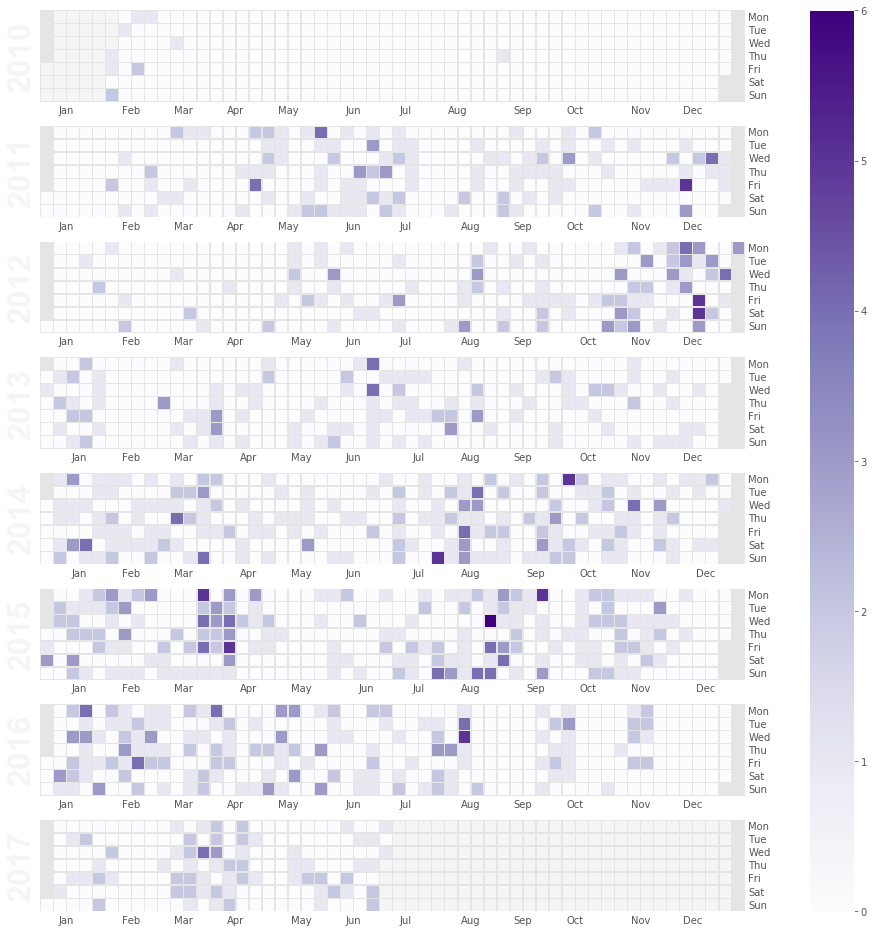

'\nTo create plots for specific years, use the following\n'

In [6]:
#other color schemes: https://matplotlib.org/examples/color/colormaps_reference.html

fig,ax=calmap.calendarplot(post_count.time, cmap='Purples', linewidth=0.5,
                    fig_kws=dict(figsize=(18,13)))
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist())

plt.show()

"""
To create plots for specific years, use the following
"""
# years = [2013, 2014, 2015, 2016, 2017]
# for year in years:
#     calmap.yearplot(count.time, year=year, cmap='Purples', linewidth=0.5)#, vmax=1, fillcolor='white')
#     plt.title(str(year))
#     plt.legend()
#     plt.show()


## Comments

In [7]:
def extract_comments(post):
    comments = post.findAll('div', class_='pas _3-94 uiBoxGray noborder')
    for comment in comments: 
        name = comment.findAll('span', class_='_3-8_ _2oao')
        time = comment.find('div', class_='_67gx').text
        comment.findAll('div')[1].text
        
a = extract_comments(posts[3419])

## Message Analysis

In [10]:
import os
rootdir = './facebook-data/messages'

message_files = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
         if file=="message.html":                
             message_files.append(os.path.join(subdir, file)) 

In [11]:
message_files[0]

'./facebook-data/messages/04538733d1/message.html'

In [12]:
error = []

In [14]:
msg_data = []
for num in range(len(message_files)):
    soup = BeautifulSoup(open(message_files[num]), "html.parser")

    messages = soup.findAll('div', class_='pam _3-95 _2pi0 _2lej uiBoxWhite noborder')

    for msg in messages:

        name = msg.find('div', class_='_3-96 _2pio _2lek _2lel')
        text = msg.find('div', class_='_3-96 _2let')
        time= msg.find('div', class_='_3-94 _2lem')
        try:
            msg_data.append([num,name.text, text.text, time.text])
        except:
            error.append(msg)

In [15]:
msg_df = pd.DataFrame(msg_data)
msg_df.columns = ['chat_no', 'sender', 'text', 'time']

#message sent by me or other person
msg_df['type'] = msg_df.sender.apply(lambda name: 'Sent' if name=='Samarth Bansal' else 'Received')

#length of message
msg_df['msg_len'] = msg_df.text.apply(lambda text: len(text))

#words in message
msg_df['msg_word_count'] = msg_df.text.apply(lambda text: len(re.findall(r'\w+', text)))

#number of members in the chat
msg_members = msg_df[['chat_no', 'sender']].groupby(['chat_no']).nunique()
msg_members.columns = ['chat', 'number_of_senders']

#number of messages in the chat
msg_counts = msg_df[['chat_no', 'sender']].groupby(['chat_no']).count()
msg_counts.columns = ['number_of_messages']

msg_add_data = msg_counts.reset_index().merge(msg_members.reset_index(), on='chat_no')
msg_add_data['member_count'] = msg_add_data.number_of_senders.apply(lambda num: 'Single' if num<=2 else 'Group')
msg_df = msg_df.merge(msg_add_data[['chat_no', 'number_of_messages', 'number_of_senders', 'member_count']], on='chat_no')



In [16]:
msg_df['time_stamp'] = msg_df.time.apply(lambda time: parser.parse(time))

In [17]:
msg_df.index = msg_df.time_stamp
msg_df = msg_df[msg_df.text!='You are now connected on Messenger.']

In [18]:
#msg_df.head()

In [19]:
num_msg_data = msg_df[['type', 'number_of_messages', 'member_count']].groupby(['member_count', 'type']).count()
msg_word_data = msg_df[['type', 'msg_word_count', 'member_count']].groupby(['member_count', 'type']).sum()


In [20]:
msg_add_data.number_of_messages.sum()

115756

In [21]:
msg_word_data

msg_word_count
member_count type                    
Group        Received          138440
             Sent               23215
Single       Received          369403
             Sent              299106

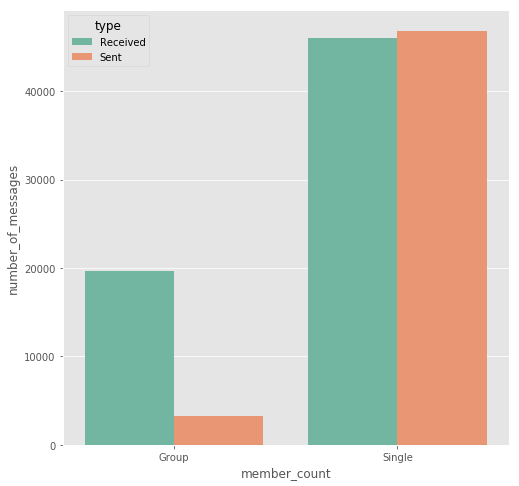

In [22]:
plt.rcParams["figure.figsize"]= (8,8)
num_msg_data.reset_index()
sns.barplot(data =num_msg_data.reset_index(), x='member_count', y='number_of_messages', hue='type', palette='Set2')
plt.show()


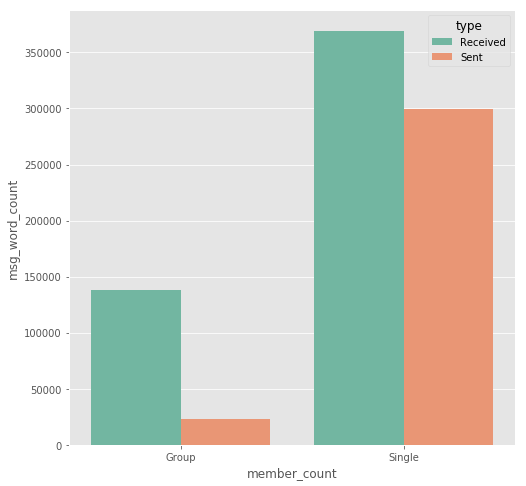

In [23]:
plt.rcParams["figure.figsize"]= (8,8)
sns.barplot(data =msg_word_data.reset_index(), x='member_count', y='msg_word_count', hue='type', palette='Set2')
plt.show()

In [24]:
#msg_df[msg_df.number_of_senders==1]

In [25]:
num_msg_data.reset_index()

,member_count,type,number_of_messages
0,Group,Received,19621
1,Group,Sent,3218
2,Single,Received,46050
3,Single,Sent,46836


In [26]:
msg_add_data[msg_add_data.number_of_messages>1].groupby('member_count').sum()

,chat_no,number_of_messages,chat,number_of_senders
member_count,,,,
Group,232505,22839,322,2369
Single,751186,92743,1000,1952


In [27]:
msg_add_data.number_of_messages.sum()

115756

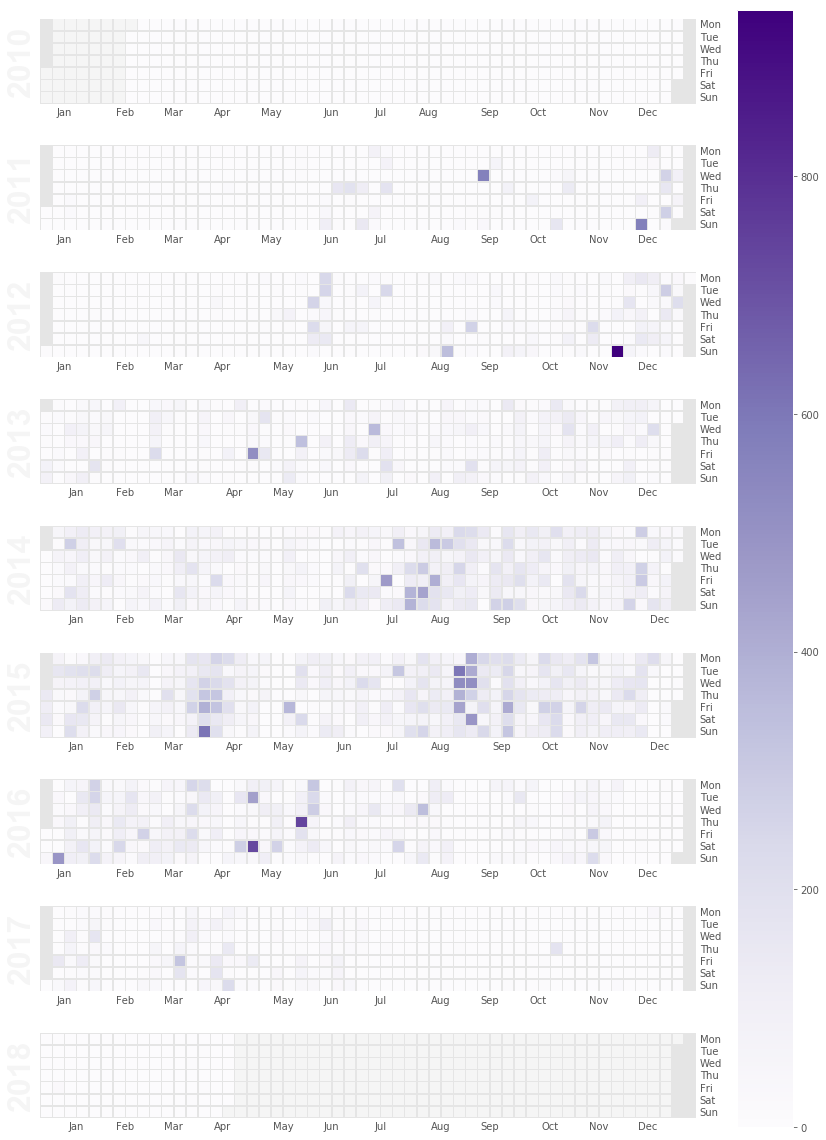

Log distribution


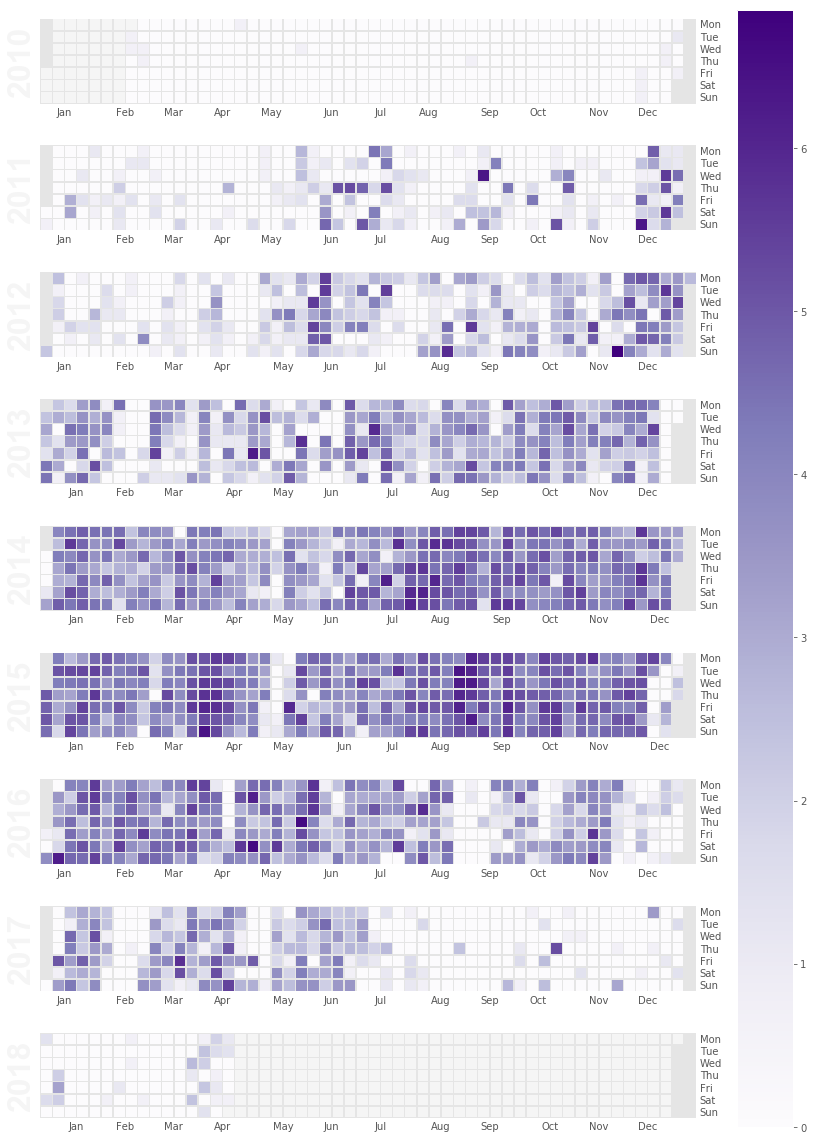

In [28]:
plt.rcParams["figure.figsize"]= (12,16)

#calmap.calendarplot(count.time, cmap='Purples', linewidth=0.5)#, vmax=1, fillcolor='white')
#plt.show()

msg_word_time = msg_df.msg_word_count.resample("D").count()


#Plot actual count or with log(x+1) transformation depending on the distribution of underlying data

#actual count of msg_word_time
fig,ax=calmap.calendarplot(msg_word_time , cmap='Purples', linewidth=0.5)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist()) 
plt.show()

print "Log distribution"
#log(x+1 transformation) for msg_word_time
fig,ax=calmap.calendarplot(np.log(msg_word_time+1) , cmap='Purples', linewidth=0.5)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist()) 

plt.show()

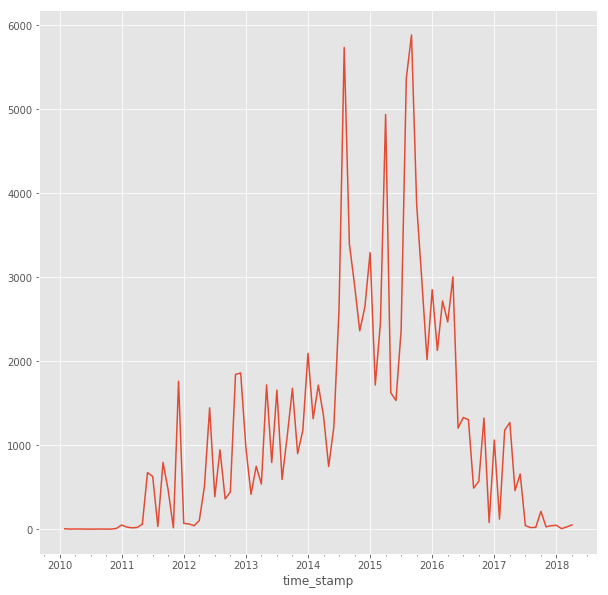

In [29]:
# msg_word_time = msg_df.msg_word_count.resample("M").count()
msg_word_time = msg_df.msg_word_count.resample("M").count()

plt.rcParams["figure.figsize"]= (10,10)
msg_word_time.plot()
 
plt.show()
# num_msg = msg_df.number_of_messages.resample("M").count()
# num_msg.plot()
# plt.title("Number of messages exchanged every month")
# plt.show()

In [30]:
#msg_df[(msg_df.chat_no.isin(msg_add_data[(msg_add_data.number_of_messages>2000) & (msg_add_data.number_of_messages>2)].chat_no) & (msg_df.member_count=='Single'))].sender.unique()


In [31]:
msg_df.columns

Index([u'chat_no', u'sender', u'text', u'time', u'type', u'msg_len',
       u'msg_word_count', u'number_of_messages', u'number_of_senders',
       u'member_count', u'time_stamp'],
      dtype='object')

In [32]:
msg_df.msg_word_count.sum()

830164

In [33]:
# plt.rcParams["figure.figsize"]= (20,10)
# swarm_data = msg_add_data[msg_add_data.number_of_messages>5][['number_of_messages', 'number_of_senders', 'member_count']]
# sns.swarmplot(y=swarm_data['number_of_messages'], x=swarm_data['member_count'],  palette="Set2")
# plt.show()
len(msg_add_data[(msg_add_data.number_of_messages<=100) & (msg_add_data.number_of_messages>2)])

1023

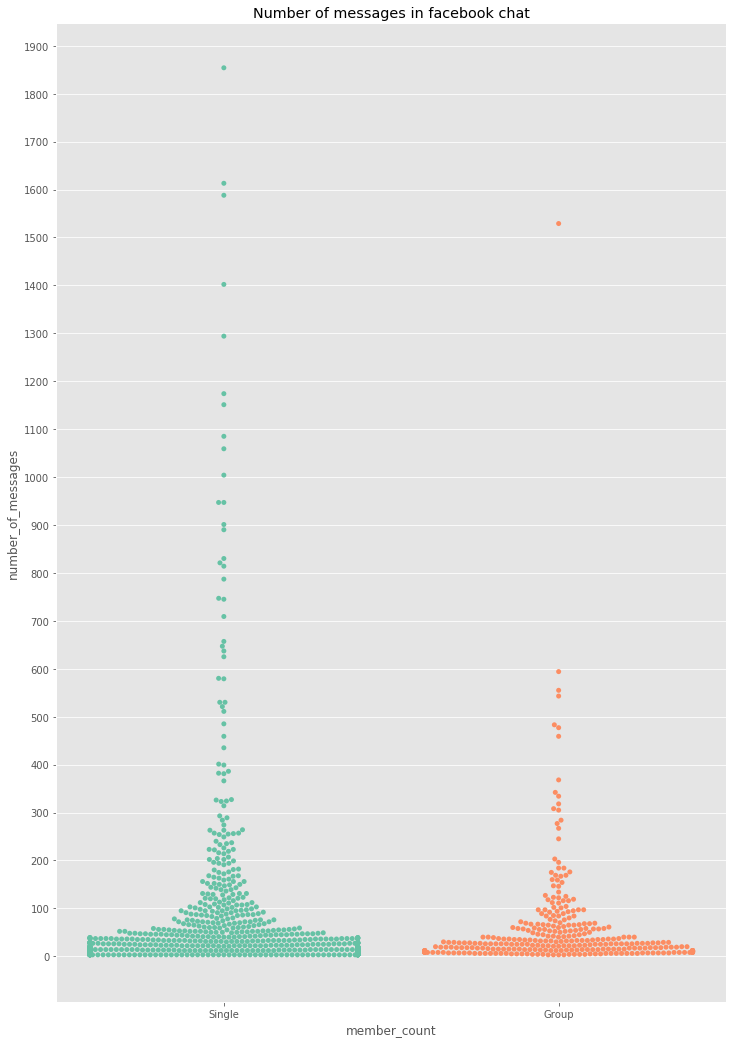

In [34]:
plt.rcParams["figure.figsize"]= (12,18)

#Plot the entire data
swarm_data = msg_add_data[['number_of_messages', 'number_of_senders', 'member_count']]

#Filter on message count before making the swarm plot
swarm_data = msg_add_data[(msg_add_data.number_of_messages>2) & (msg_add_data.number_of_messages<2000) ][['number_of_messages', 'number_of_senders', 'member_count']]
ax = sns.swarmplot(y=swarm_data['number_of_messages'], x=swarm_data['member_count'],  palette="Set2")

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.title('Number of messages in facebook chat')
plt.show()

## Friends Added analysis

In [35]:
url = "facebook-data/friends/friends_added.html"
soup = BeautifulSoup(open(url), "html.parser")

In [36]:
friends = soup.findAll('div', class_='pam _3-95 _2pi0 _2lej uiBoxWhite noborder')

In [37]:
friend_data = []
for num in range(len(friends)):
    time = friends[num].find('div', class_='_3-94 _2lem').text
    friend_data.append([len(friends) - num, parser.parse(time)])

In [38]:
friend_data = pd.DataFrame(friend_data)

In [39]:
friend_data.columns = ['total_friends', 'timestamp']

In [40]:
friend_data.index = friend_data.timestamp

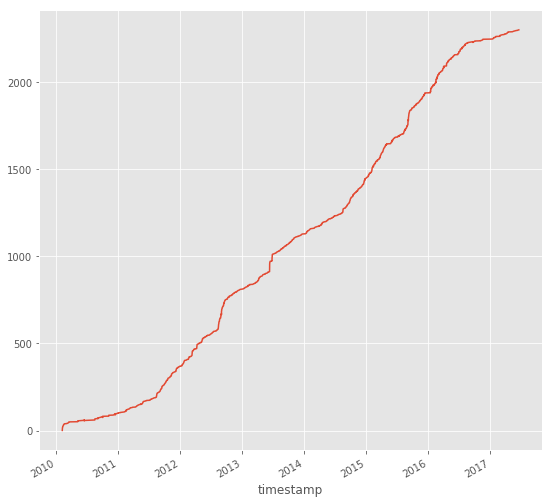

In [41]:
plt.rcParams["figure.figsize"]= (9,9)
friend_data.total_friends.plot()
plt.show()

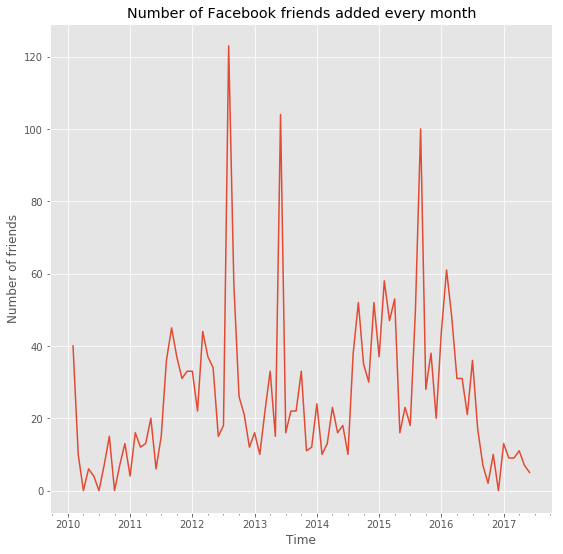

In [42]:
plt.rcParams["figure.figsize"]= (9,9)
friend_data.total_friends.resample("M").count().plot()
plt.title('Number of Facebook friends added every month')
plt.ylabel('Number of friends')
plt.xlabel('Time')
plt.show()

## posts and comments

In [43]:
url = "facebook-data/likes_and_reactions/posts_and_comments.html"
soup = BeautifulSoup(open(url), "html.parser")
likes = soup.findAll('div', class_='pam _3-95 _2pi0 _2lej uiBoxWhite noborder')

In [44]:
like_data = []
for like in likes:
    time = like.find('div', class_='_3-94 _2lem')
    like_data.append([parser.parse(time.text), 1])

In [45]:
like_data = pd.DataFrame(like_data)


In [47]:
#like_data

In [48]:
like_data.columns = ['time', 'temp']

In [49]:
like_data.index = like_data.time

In [50]:
like_count = like_data.temp.resample("M").sum()

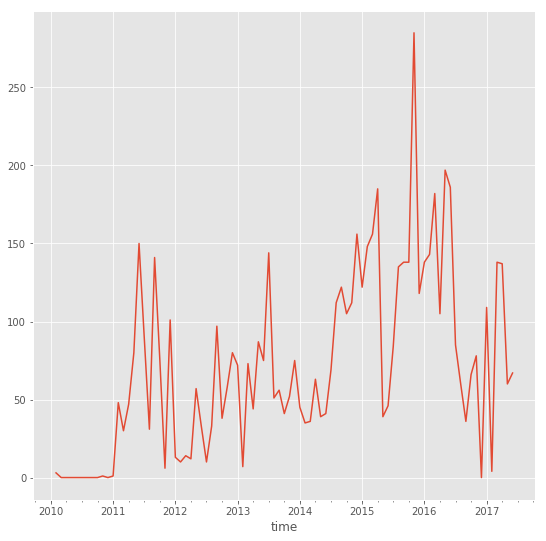

In [51]:
like_count.plot()
plt.show()

## deactivation

In [52]:
url = "facebook-data/security_and_login_information/account_status_changes.html"
soup = BeautifulSoup(open(url), "html.parser")
status = soup.findAll('div', class_='_4-u2 _3-94 _4-u8')

In [53]:
status_data = []
for i in status:
    title = i.find('div', class_='_4-u3 _5dwa _5dw9').text[8:]
    time = i.find('div', class_='_4-u3 _2ph_').text[5:]
    time_parsed = parser.parse(time)
    status_data.append([title,time, time_parsed])
    

In [54]:
acc_status  = pd.DataFrame(status_data, columns=['status', 'time', 'timestamp'])

In [55]:
deactivated = acc_status[acc_status.status=='deactivated']
deactivated['id'] = deactivated.timestamp.rank()

reactivated = acc_status[acc_status.status=='reactivated']
reactivated['id'] = reactivated.timestamp.rank()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
reactivated['id'] = reactivated.timestamp.rank()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
status_new = deactivated.merge(reactivated, on='id')

In [58]:
status_new.columns = ['status_deactive', 'time_deactive', 'timestamp_deactive', 'id', 'status_reactive', 'time_reactive', 'timestamp_reactive']

In [59]:
status_new['diff_days'] = status_new.apply(lambda row: (row.timestamp_reactive - row.timestamp_deactive).days, axis=1 ) 

In [60]:
from datetime import datetime, timedelta

In [61]:
#status_new[status_new.diff_days>1]

In [62]:
deactive_time = status_new[status_new.diff_days>1]


In [63]:
datetime(2010, 2, 4).date()

datetime.date(2010, 2, 4)

In [64]:
import matplotlib.dates as mdates

#set dates — the day when you joined Facebook and current date
dates = mdates.num2date(mdates.drange(datetime(2010, 2, 4).date(),
                                      datetime(2018, 4, 30).date(),
                                      timedelta(days=1)))




In [65]:
new_dates = []
for i in dates:
    new_dates.append(i.replace(tzinfo=None))

In [66]:
new_dates

[datetime.datetime(2010, 2, 4, 0, 0),
 datetime.datetime(2010, 2, 5, 0, 0),
 datetime.datetime(2010, 2, 6, 0, 0),
 datetime.datetime(2010, 2, 7, 0, 0),
 datetime.datetime(2010, 2, 8, 0, 0),
 datetime.datetime(2010, 2, 9, 0, 0),
 datetime.datetime(2010, 2, 10, 0, 0),
 datetime.datetime(2010, 2, 11, 0, 0),
 datetime.datetime(2010, 2, 12, 0, 0),
 datetime.datetime(2010, 2, 13, 0, 0),
 datetime.datetime(2010, 2, 14, 0, 0),
 datetime.datetime(2010, 2, 15, 0, 0),
 datetime.datetime(2010, 2, 16, 0, 0),
 datetime.datetime(2010, 2, 17, 0, 0),
 datetime.datetime(2010, 2, 18, 0, 0),
 datetime.datetime(2010, 2, 19, 0, 0),
 datetime.datetime(2010, 2, 20, 0, 0),
 datetime.datetime(2010, 2, 21, 0, 0),
 datetime.datetime(2010, 2, 22, 0, 0),
 datetime.datetime(2010, 2, 23, 0, 0),
 datetime.datetime(2010, 2, 24, 0, 0),
 datetime.datetime(2010, 2, 25, 0, 0),
 datetime.datetime(2010, 2, 26, 0, 0),
 datetime.datetime(2010, 2, 27, 0, 0),
 datetime.datetime(2010, 2, 28, 0, 0),
 datetime.datetime(2010, 3, 1, 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


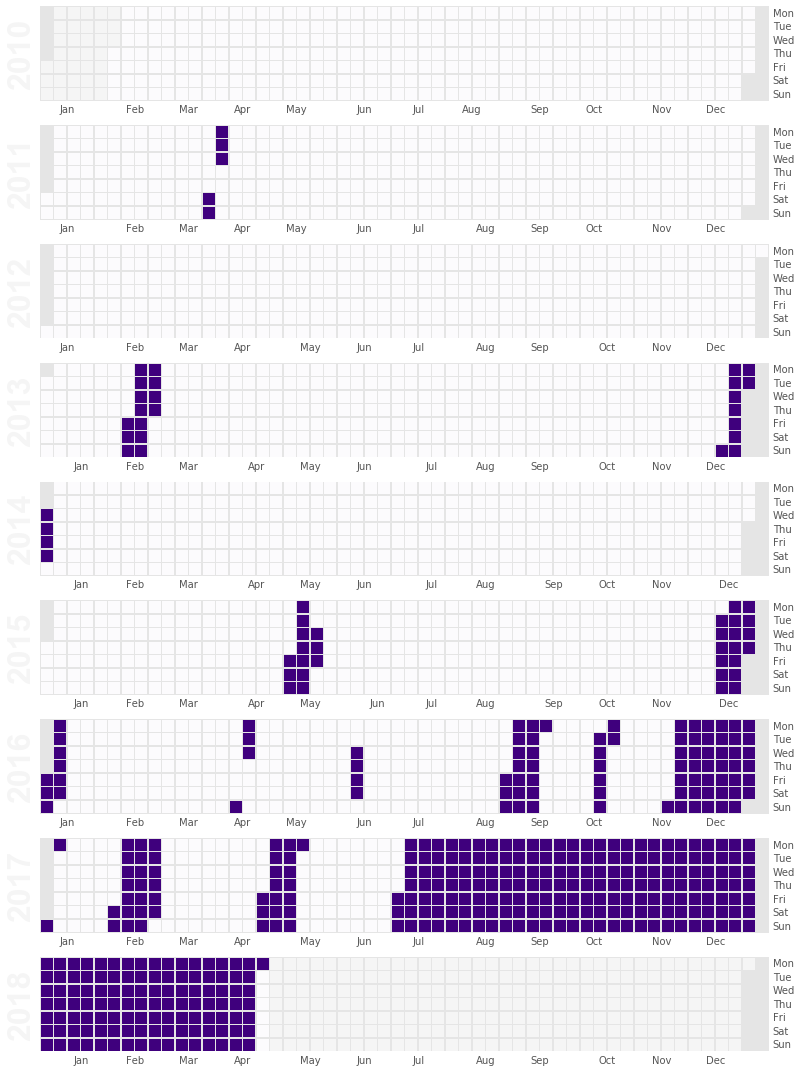

In [67]:
status_chart = pd.DataFrame(index=new_dates)
status_chart['val'] = 0

for index, row in deactive_time.iterrows():
    start_date = row['timestamp_deactive']
    end_date = row['timestamp_reactive']
    
    daterange = pd.date_range(start_date.date(), end_date.date())
    for i in daterange:
        status_chart.set_value(i, 'val', 1)
        
status_chart_new = status_chart.resample("D").sum()
calmap.calendarplot(status_chart_new.val, cmap='Purples', linewidth=0.5,
                    fig_kws=dict(figsize=(13,15)))
plt.show()
